# predicting income from census data

This notebook trains a model using US census data

Details on the dataset can be found at https://archive.ics.uci.edu/ml/datasets/Census+Income

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# shap explainer
import shap

print(tf.__version__)

1.14.0


In [2]:
# import data files
train_data = pd.read_csv('data/adult.data.csv', index_col=False,\
                         names=['age','workclass','fnlwgt','education',\
                            'education-num','marital-status','occupation',\
                            'relationship','race','sex','capital-gain','capital-loss',\
                            'hours-per-week','native-country','salary'])
test_data = pd.read_csv('data/adult.test.csv', index_col=False,\
                         names=['age','workclass','fnlwgt','education',\
                            'education-num','marital-status','occupation',\
                            'relationship','race','sex','capital-gain','capital-loss',\
                            'hours-per-week','native-country','salary'])

## exploring the dataset

In this dataset, each record represents an individual and contains information about them as well as an indicator of whether their salary is greater or less than $50,000 USD.

In [3]:
# preview data
train_data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


We will need to create a new binary field based on the salary to use for the labels

In [4]:
# create label field as integer in train data
train_data['over50K'] = (train_data['salary'] == ' >50K').astype(int)
# also create label field in test data
test_data['over50K'] = (test_data['salary'] == ' >50K').astype(int)
# preview data
train_data.head(10)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary,over50K
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,0
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K,0
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K,0
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K,1
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K,1
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K,1


We will create a training label dataset using the new indicator we created

In [5]:
# create training labels dataset
train_labels = train_data.iloc[:,-1]
# also create test labels dataset
test_labels = test_data.iloc[:,-1]
# preview data
train_labels[0:10]

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    1
8    1
9    1
Name: over50K, dtype: int64

Now we can drop the labels and other fields we will not use in training the model

In [6]:
# remove labels and other fields from training data and test data
train_data.drop(['salary','over50K','fnlwgt','capital-gain','capital-loss'], axis=1, inplace=True)
test_data.drop(['salary','over50K','fnlwgt','capital-gain','capital-loss'], axis=1, inplace=True)
# preview data
train_data.head(10)

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,hours-per-week,native-country
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,40,United-States
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,13,United-States
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,40,United-States
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,40,United-States
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,40,Cuba
5,37,Private,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,40,United-States
6,49,Private,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,16,Jamaica
7,52,Self-emp-not-inc,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,45,United-States
8,31,Private,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,50,United-States
9,42,Private,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,40,United-States


## data transformations

Since we have a number of categorical variables, we will need a way to encode them as numeric values. For simplicity, we will use one hot encoding and only keep the most frequent values and group the rest in an 'other' category in order to reduce the number of dimensions.

First, lets see how many unique values we have across each categorical variable.

Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object')


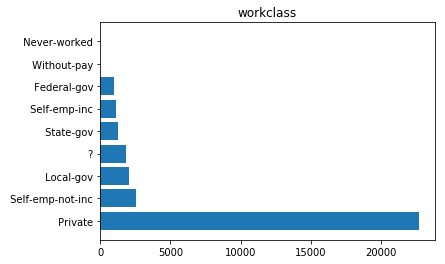

number of unique values 9


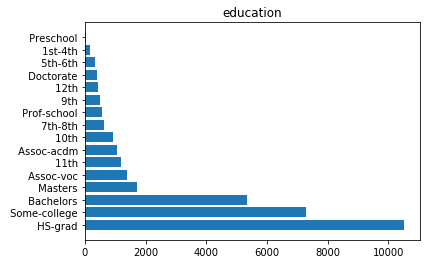

number of unique values 16


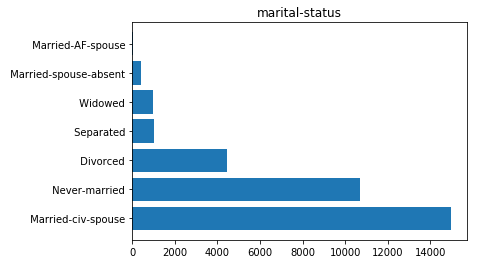

number of unique values 7


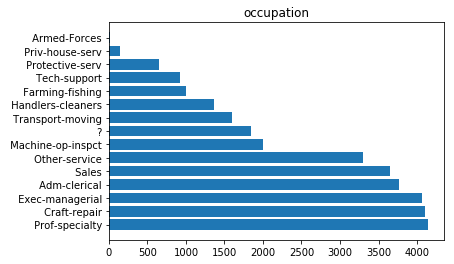

number of unique values 15


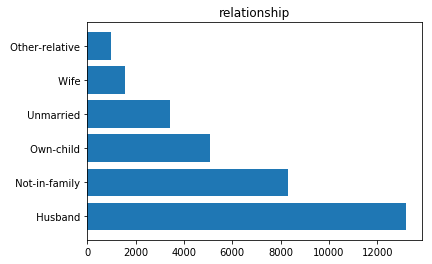

number of unique values 6


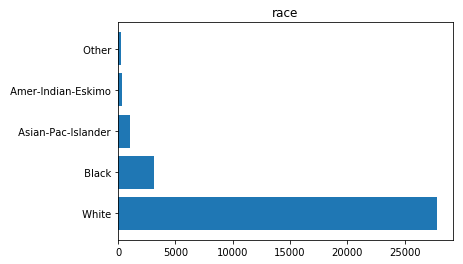

number of unique values 5


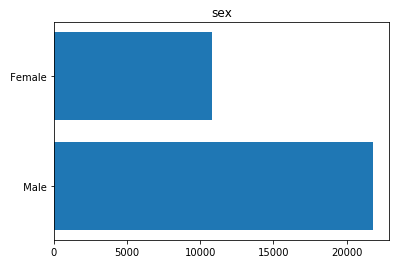

number of unique values 2


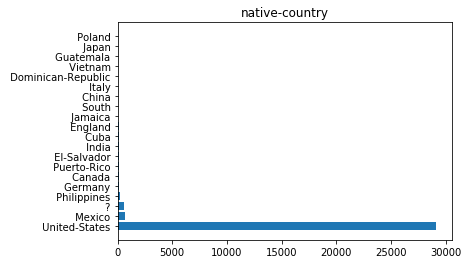

number of unique values 42


In [7]:
# create a dataframe for object data types so we can aggregate categories
obj_df = train_data.select_dtypes(include=['object']).copy()
print(obj_df.columns)
# visualize distribution of records across top values for each column
for _ in obj_df.columns:
    y_plot = obj_df.groupby(_)[_].count().sort_values(ascending=False)
    x_plot = y_plot.index
    plt.barh(x_plot[0:20],y_plot[0:20])
    plt.title(_)
    plt.show()
    print('number of unique values', obj_df[_].nunique())

After grouping the less frequent values, our data looks as follows.

In [8]:
# reduce the number of possible values for categorical fields

# define number of feature values to include for each feature
n_items = 5

# create a function to group items based on most frequently occurring
def item_map (series):
    n = 0
    while n < n_items - 1:
        if (series[field] == top_items[n]):
            return str.lower(top_items[n])
        n += 1
    else:
        return 'other'

# group categorical data into broader buckets
for _ in obj_df.columns:
    field = _
    top_items = obj_df[field].value_counts().keys()[0:n_items]
    df_mapped = train_data[[field]].apply(item_map, axis='columns')
    train_data[field] = df_mapped

# do the same for test data
for _ in obj_df.columns:
    field = _
    top_items = obj_df[field].value_counts().keys()[0:n_items]
    df_mapped = test_data[[field]].apply(item_map, axis='columns')
    test_data[field] = df_mapped

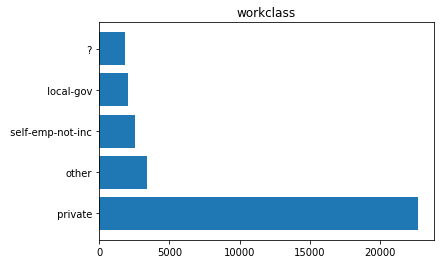

number of unique values 5


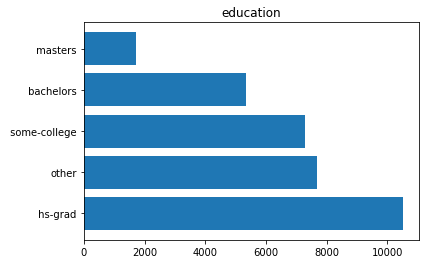

number of unique values 5


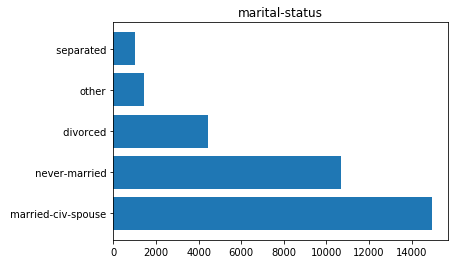

number of unique values 5


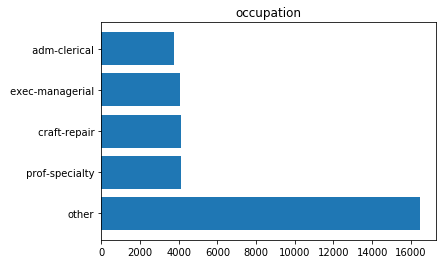

number of unique values 5


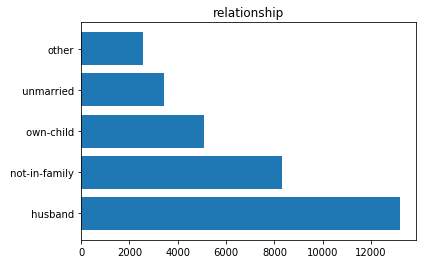

number of unique values 5


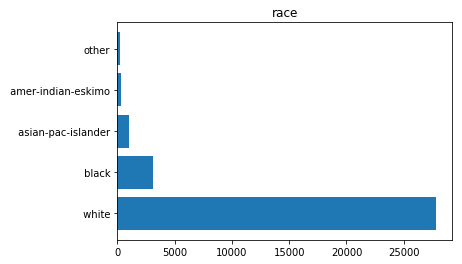

number of unique values 5


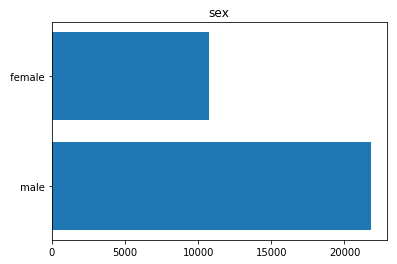

number of unique values 2


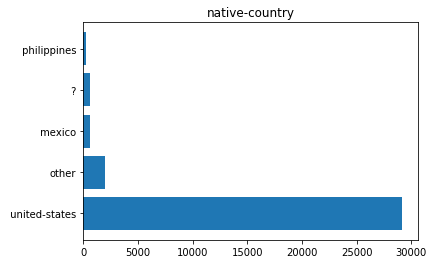

number of unique values 5


In [9]:
# visualize new classification
obj_df2 = train_data.select_dtypes(include=['object']).copy()

for _ in obj_df2.columns:
    y_plot = obj_df2.groupby(_)[_].count().sort_values(ascending=False)
    x_plot = y_plot.index
    plt.barh(x_plot[0:20],y_plot[0:20])
    plt.title(_)
    plt.show()
    print('number of unique values', obj_df2[_].nunique())

The next step is to one hot encode the data and update the column names

In [10]:
# create a new dataframe that converts to one hot encoding
train_data_input = pd.get_dummies(train_data)
# also one hot encode the test data
test_data_input = pd.get_dummies(test_data)
# rename columns
train_data_input.columns = (['age', 'education-num', 'hours-per-week', 'workclass_unknown',
       'workclass_local-gov', 'workclass_private',
       'workclass_self-emp-not-inc', 'workclass_other',
       'education_bachelors', 'education_hs-grad', 'education_masters',
       'education_some-college', 'education_other',
       'marital-status_divorced', 'marital-status_married-civ-spouse',
       'marital-status_never-married', 'marital-status_separated',
       'marital-status_other', 'occupation_adm-clerical',
       'occupation_craft-repair', 'occupation_exec-managerial',
       'occupation_prof-specialty', 'occupation_other',
       'relationship_husband', 'relationship_not-in-family',
       'relationship_own-child', 'relationship_unmarried',
       'relationship_other', 'race_amer-indian-eskimo',
       'race_asian-pac-islander', 'race_black', 'race_white', 'race_other',
       'sex_female', 'sex_male', 'native-country_unknown',
       'native-country_mexico', 'native-country_philippines',
       'native-country_united-states', 'native-country_other'])
test_data_input.columns = (['age', 'education-num', 'hours-per-week', 'workclass_unknown',
       'workclass_local-gov', 'workclass_private',
       'workclass_self-emp-not-inc', 'workclass_other',
       'education_bachelors', 'education_hs-grad', 'education_masters',
       'education_some-college', 'education_other',
       'marital-status_divorced', 'marital-status_married-civ-spouse',
       'marital-status_never-married', 'marital-status_separated',
       'marital-status_other', 'occupation_adm-clerical',
       'occupation_craft-repair', 'occupation_exec-managerial',
       'occupation_prof-specialty', 'occupation_other',
       'relationship_husband', 'relationship_not-in-family',
       'relationship_own-child', 'relationship_unmarried',
       'relationship_other', 'race_amer-indian-eskimo',
       'race_asian-pac-islander', 'race_black', 'race_white', 'race_other',
       'sex_female', 'sex_male', 'native-country_unknown',
       'native-country_mexico', 'native-country_philippines',
       'native-country_united-states', 'native-country_other'])
# preview new dataframe
train_data_input.head()

,age,education-num,hours-per-week,workclass_unknown,workclass_local-gov,workclass_private,workclass_self-emp-not-inc,workclass_other,education_bachelors,education_hs-grad,...,race_black,race_white,race_other,sex_female,sex_male,native-country_unknown,native-country_mexico,native-country_philippines,native-country_united-states,native-country_other
0,39,13,40,0,0,0,0,1,1,0,...,0,1,0,0,1,0,0,0,1,0
1,50,13,13,0,0,0,1,0,1,0,...,0,1,0,0,1,0,0,0,1,0
2,38,9,40,0,0,1,0,0,0,1,...,0,1,0,0,1,0,0,0,1,0
3,53,7,40,0,0,1,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
4,28,13,40,0,0,1,0,0,1,0,...,1,0,0,1,0,0,0,0,0,1


## training the model

We will train our data on a Keras dense neural network

In [11]:
# configure model
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(40,)),
    keras.layers.Dense(10, activation=tf.nn.relu),
    keras.layers.Dense(2, activation=tf.nn.softmax)
])

W0718 23:54:44.374167 140499279365888 deprecation.py:506] From /home/jupyter/.local/lib/python3.5/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [12]:
# compile model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
# fit model
model.fit(train_data_input, train_labels, epochs=5)

Epoch 1/5
32561/32561 [==============================] - 1s 44us/sample - loss: 0.8342 - acc: 0.7714
Epoch 2/5
32561/32561 [==============================] - 1s 39us/sample - loss: 0.3783 - acc: 0.8260
Epoch 3/5
32561/32561 [==============================] - 1s 39us/sample - loss: 0.3727 - acc: 0.8260
Epoch 4/5
32561/32561 [==============================] - 1s 41us/sample - loss: 0.3697 - acc: 0.8253
Epoch 5/5
32561/32561 [==============================] - 1s 40us/sample - loss: 0.3692 - acc: 0.8264


## evaluating the model

Evaluating our model we can see that we get a prediction accuracy of ~83%

In [14]:
# evaluate model
test_loss, test_acc = model.evaluate(test_data_input, test_labels)

print('Test accuracy:', test_acc)

16278/16278 [==============================] - 0s 25us/sample - loss: 0.3577 - acc: 0.8322
Test accuracy: 0.8322275


# model explainability

We will use the SHAP library to generate explanations to our models

More details on SHAP can be found here: https://github.com/slundberg/shap

In [15]:
# convert data inputs into numpy arrays
shap_train_data = np.array(train_data_input[:100])
shap_test_data = np.array(test_data_input[:10])

In [16]:
# we use the first 100 training examples as our background dataset to integrate over
explainer = shap.DeepExplainer(model, shap_train_data)

Using TensorFlow backend.
W0718 23:54:51.874038 140499279365888 deprecation_wrapper.py:119] From /home/jupyter/shap/shap/explainers/deep/deep_tf.py:119: The name tf.keras.backend.get_session is deprecated. Please use tf.compat.v1.keras.backend.get_session instead.



In [17]:
# explain the predictions
shap_values = explainer.shap_values(shap_test_data)

W0718 23:54:51.938973 140499279365888 deprecation.py:323] From /home/jupyter/shap/shap/explainers/deep/deep_tf.py:490: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [18]:
# check the shape of the shap_values which has the same shape as our test data
shap_values[0].shape

(10, 40)

In [19]:
# explainer.expected_value adds up to one and gives probability of the classes
explainer.expected_value

array([0.7401856 , 0.25981438], dtype=float32)

In [20]:
# create list of feature names
feature_name_list = train_data_input.columns

In [21]:
# load JS visualization code to notebook
shap.initjs()

We can use SHAP to visualize the predictions in a way that shows how features contribute to the prediction. Here are the explanations for the first three records in the test data

In [22]:
shap.force_plot(explainer.expected_value[0],shap_values[0][0], shap_test_data[0], feature_names=(feature_name_list))

In [23]:
shap.force_plot(explainer.expected_value[0],shap_values[0][1], shap_test_data[1], feature_names=(feature_name_list))

In [24]:
shap.force_plot(explainer.expected_value[0],shap_values[0][2], shap_test_data[2], feature_names=(feature_name_list))

Similarly we log the predictions with detailed explanations and see that we get the same probabilities

Note that the probability of a given sample being in a class is the sum of the expected value from the explainer and the shap values for that sample

In [25]:
# iterate through shap_values for each of the first 3 samples
for i in range(0, 3):
    probability_class_0 = (explainer.expected_value[0] + sum(shap_values[0][i]))
    prediction = (probability_class_0 > .5)
    print('baseline: {}'.format(explainer.expected_value[0]))
    print('shift: {}'.format(sum(shap_values[0][i])))
    print('probability: {}'.format(probability_class_0))
    print('predicted: {}\n'.format(prediction))
    
    for j in range(0, len(shap_values[0][i])):
        print('feature: {} value: {} weight: {}'.format(feature_name_list[j], test_data_input.iloc[i][j], shap_values[0][i][j]))
    print('\n')

baseline: 0.7401856184005737
shift: 0.25636089217168784
probability: 0.9965465105722615
predicted: True

feature: age value: 25 weight: -0.11470382612013054
feature: education-num value: 7 weight: 0.22591524679068242
feature: hours-per-week value: 40 weight: -0.25034502153037463
feature: workclass_unknown value: 0 weight: 0.0008787556365132332
feature: workclass_local-gov value: 0 weight: -0.00225460366345942
feature: workclass_private value: 1 weight: 0.026338262282079087
feature: workclass_self-emp-not-inc value: 0 weight: -0.019718721469689626
feature: workclass_other value: 0 weight: -0.008821651777252556
feature: education_bachelors value: 0 weight: -0.0030958823405671863
feature: education_hs-grad value: 0 weight: -0.003398838488064939
feature: education_masters value: 0 weight: -0.0022675376385450363
feature: education_some-college value: 0 weight: -0.007158833402208984
feature: education_other value: 1 weight: 0.01834697605459951
feature: marital-status_divorced value: 0 weight